# I Load Libary

In [27]:
import os
import shutil
import glob
import random
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Aktifkan mode inline untuk menampilkan gambar langsung di notebook
%matplotlib inline

# II Path

In [37]:
DATASET_PATH = "D:/Skripsi/scv2/Indonesian Spices Dataset"
OUTPUT_PATH = "D:/Skripsi/scv2/dataset_processed"
TRAIN_PATH, VALID_PATH, TEST_PATH = [os.path.join(OUTPUT_PATH, folder) for folder in ["train", "valid", "test"]]

# III Add TRAIN VAL TEST

In [38]:
for path in [TRAIN_PATH, VALID_PATH, TEST_PATH]:
    os.makedirs(path, exist_ok=True)

# 4.Baca Class Rempah

In [39]:
classes = os.listdir(DATASET_PATH)
print(f"Ditemukan {len(classes)} kelas rempah.")

Ditemukan 31 kelas rempah.


# 5. Fungsi untuk memindahkan gambar ke folder baru

In [40]:
def move_files(file_list, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for file in file_list:
        shutil.copy(file, dest_folder)


# 6. Split Dataset dan Simpan ke Folder

In [41]:
def process_dataset():
    for class_name in classes:
        class_path = os.path.join(DATASET_PATH, class_name)
        images = glob.glob(os.path.join(class_path, "*.jpg"))  # Pastikan format file sesuai
        
        # Split dataset menjadi train (70%), validasi (20%), test (10%)
        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

        # Simpan ke folder masing-masing
        move_files(train_imgs, os.path.join(TRAIN_PATH, class_name))
        move_files(valid_imgs, os.path.join(VALID_PATH, class_name))
        move_files(test_imgs, os.path.join(TEST_PATH, class_name))

process_dataset()
print("✅ Dataset telah dipisahkan otomatis!")

✅ Dataset telah dipisahkan otomatis!


# 7. Preprocessing Gambar

In [33]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize ke 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB agar tampil dengan benar di Matplotlib
    img = img / 255.0  # Normalisasi
    return img

# 8. Augmentasi Gambar

In [34]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5)
])

def apply_augmentation(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize gambar
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB agar tampilan benar
    augmented = augment(image=img)
    return augmented["image"]

# Menampilkan Contoh Gambar

In [42]:
def show_images(original, augmented):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Memperbesar tampilan gambar
    axes[0].imshow(original)
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis("off")  # Menghilangkan koordinat
    axes[1].imshow(augmented)
    axes[1].set_title("Augmented Image", fontsize=12)

# Menampilkan hasil preprocessing dan augmentasi

✅ Proses preprocessing dan augmentasi selesai!


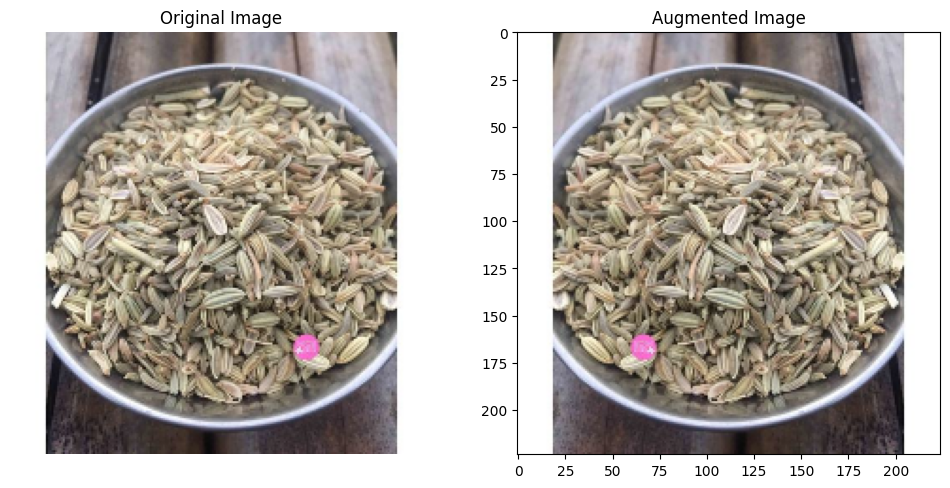

In [36]:
sample_image_path = random.choice(glob.glob(os.path.join(TRAIN_PATH, classes[0], "*.jpg")))
original = preprocess_image(sample_image_path)
augmented = apply_augmentation(sample_image_path)

show_images(original, augmented)
print("✅ Proses preprocessing dan augmentasi selesai!")